In [1]:
# =========================================================
# step0. 匯入套件
# =========================================================
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# =========================================================
# step1. 定義 MediaPipe Pose 部位分群
# =========================================================
body_parts = {
    "head": list(range(0, 11)),
    "left_arm": [11, 13, 15, 17, 19, 21],
    "right_arm": [12, 14, 16, 18, 20, 22],
    "left_leg": [23, 25, 27, 29, 31],
    "right_leg": [24, 26, 28, 30, 32],
    "torso": [11, 12, 23, 24]
}

In [3]:
# =========================================================
# step2. VQ-VAE 模型定義（同你原始版本）
# =========================================================
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, x):
        distances = (
            torch.sum(x**2, dim=1, keepdim=True) +
            torch.sum(self.embedding.weight**2, dim=1) -
            2 * torch.matmul(x, self.embedding.weight.t())
        )
        encoding_indices = torch.argmin(distances, dim=1)
        quantized = self.embedding(encoding_indices)
        return quantized, encoding_indices

class VQVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=32, num_embeddings=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.vq = VectorQuantizer(num_embeddings, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        z_q, indices = self.vq(z)
        x_recon = self.decoder(z_q)
        return x_recon, indices, z, z_q

In [4]:
# =========================================================
# step3. 載入資料與前處理
# =========================================================
def parse_point(s):
    s = str(s).strip("()")
    vals = []
    for v in s.split(","):
        try:
            vals.append(float(v.strip(" '")))
        except:
            vals.append(0.0)
    return vals

def csv_to_pose_array(csv_path):
    df = pd.read_csv(csv_path)
    pose_cols = [c for c in df.columns if c != "frame"]
    poses = []
    for _, row in df.iterrows():
        frame = []
        for c in pose_cols:
            frame += parse_point(row[c])
        poses.append(frame)
    return np.array(poses)

test_folder = "./ballet_test/"
file_pose_map = {}
for f in sorted(os.listdir(test_folder)):
    if f.endswith(".csv"):
        file_pose_map[f] = csv_to_pose_array(os.path.join(test_folder, f))

In [5]:
# =========================================================
# step4. 針對每個部位建立 scaler 與模型
# =========================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EMBEDDINGS = 64
LATENT_DIM = 32

part_models = {}
part_scalers = {}

for part, joints in body_parts.items():
    idxs = np.ravel([[i*3 + j for j in range(3)] for i in joints])
    input_dim = len(idxs)
    part_models[part] = VQVAE(input_dim=input_dim, latent_dim=LATENT_DIM, num_embeddings=NUM_EMBEDDINGS).to(device)
    part_scalers[part] = StandardScaler()

In [6]:
# =========================================================
# step5. 將每個部位的資料抽出並標準化、通過模型
# =========================================================
pose_latent_vectors = {}   # 每幀 -> 多部位 latent 向量
pose_cluster_labels = {}   # 每幀 -> 多部位 cluster label
kmeans_models = {}

for part, model in part_models.items():
    print(f"Processing part: {part}")
    # 收集所有該部位資料
    all_part_data = []
    file_ranges = {}
    start = 0
    for name, pose in file_pose_map.items():
        idxs = np.ravel([[i*3 + j for j in range(3)] for i in body_parts[part]])
        part_data = pose[:, idxs]
        all_part_data.append(part_data)
        file_ranges[name] = (start, start + part_data.shape[0])
        start += part_data.shape[0]
    all_part_data = np.concatenate(all_part_data, axis=0)

    # 標準化
    scaler = part_scalers[part]
    all_scaled = scaler.fit_transform(all_part_data)

    # Tensor
    x = torch.tensor(all_scaled, dtype=torch.float32).to(device)
    with torch.no_grad():
        _, _, _, z_q = model(x)
    z_latent = z_q.cpu().numpy()

    # KMeans 分群
    NUM_CLUSTERS = 6
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
    labels = kmeans.fit_predict(z_latent)
    kmeans_models[part] = kmeans

    # 回填各檔案對應區段
    for name, (s, e) in file_ranges.items():
        if name not in pose_cluster_labels:
            pose_cluster_labels[name] = {}
        pose_cluster_labels[name][part] = labels[s:e]

Processing part: head
Processing part: left_arm
Processing part: right_arm
Processing part: left_leg
Processing part: right_leg
Processing part: torso


In [7]:
# =========================================================
# step6. 整合多部位 cluster 結果
# =========================================================
multi_action_vectors = {}
for name, part_dict in pose_cluster_labels.items():
    num_frames = len(next(iter(part_dict.values())))
    combined = []
    for i in range(num_frames):
        frame_vec = [part_dict[p][i] for p in part_models.keys()]
        combined.append(frame_vec)
    multi_action_vectors[name] = np.array(combined)

In [8]:
# =========================================================
# step7. 存成 JSON
# =========================================================
json_path = "ballet_multi_part_clusters.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump({k: v.tolist() for k, v in multi_action_vectors.items()}, f, indent=4, ensure_ascii=False)
print(f"💾 多部位分群結果已存成 {json_path}")

💾 多部位分群結果已存成 ballet_multi_part_clusters.json


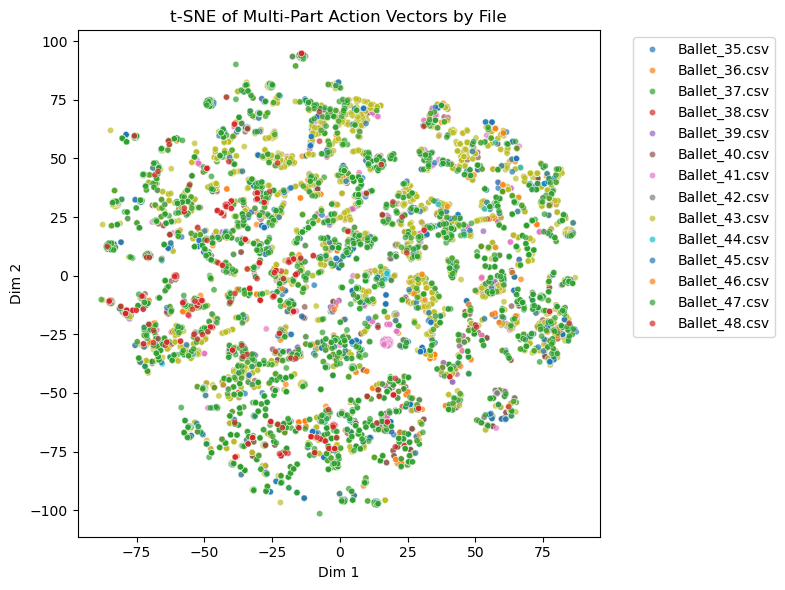

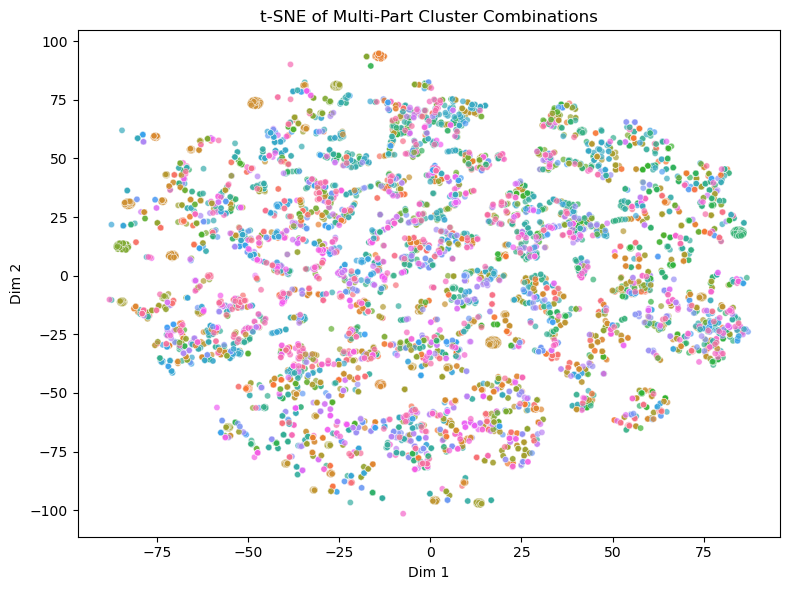

In [9]:
# =========================================================
# step8. 以 T-SNE 可視化多部位動作共存分布（改良版）
# =========================================================
all_vecs = np.concatenate(list(multi_action_vectors.values()), axis=0)

# 建立對應檔案來源的標籤
file_labels = []
for name, vecs in multi_action_vectors.items():
    file_labels.extend([name] * len(vecs))
file_labels = np.array(file_labels)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d = tsne.fit_transform(all_vecs)

# 散點圖，依檔案上色
plt.figure(figsize=(8,6))
sns.scatterplot(x=latent_2d[:,0], y=latent_2d[:,1], hue=file_labels, s=20, alpha=0.7, palette="tab10")
plt.title("t-SNE of Multi-Part Action Vectors by File")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 可選：將 cluster 組合轉成字符串作為標籤
cluster_labels = []
for vec in all_vecs:
    cluster_labels.append("-".join([str(int(x)) for x in vec]))
cluster_labels = np.array(cluster_labels)

# t-SNE 散點圖，依 cluster 組合上色
plt.figure(figsize=(8,6))
sns.scatterplot(x=latent_2d[:,0], y=latent_2d[:,1], hue=cluster_labels, s=20, alpha=0.7, legend=False)
plt.title("t-SNE of Multi-Part Cluster Combinations")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

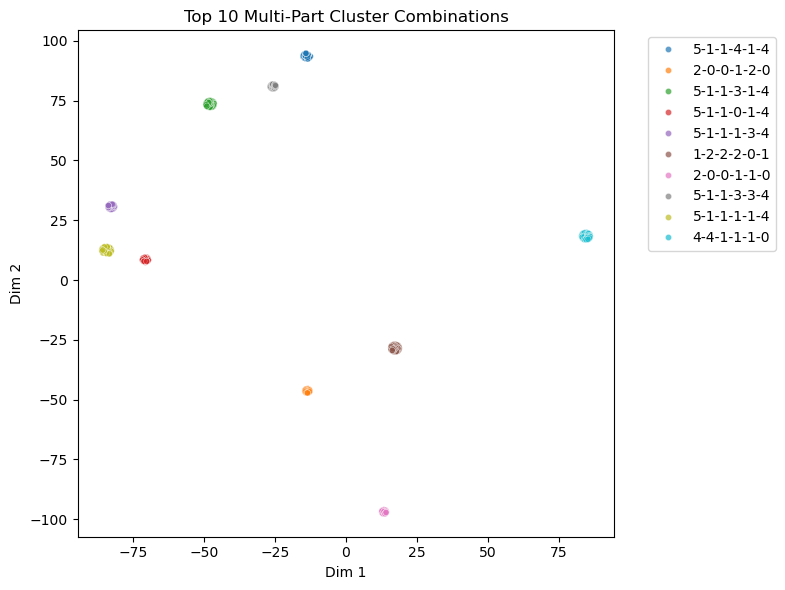

In [10]:
from collections import Counter
cnt = Counter(cluster_labels)
top_clusters = [c for c,_ in cnt.most_common(10)]
mask = np.isin(cluster_labels, top_clusters)
plt.figure(figsize=(8,6))
sns.scatterplot(x=latent_2d[mask,0], y=latent_2d[mask,1], hue=cluster_labels[mask],
                s=20, alpha=0.7)
plt.title("Top 10 Multi-Part Cluster Combinations")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

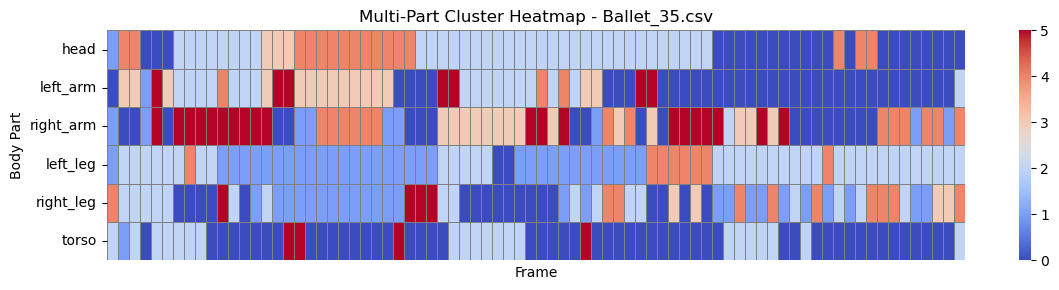

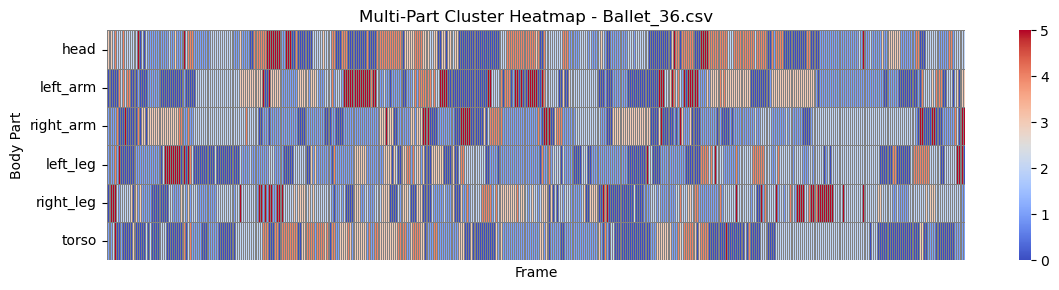

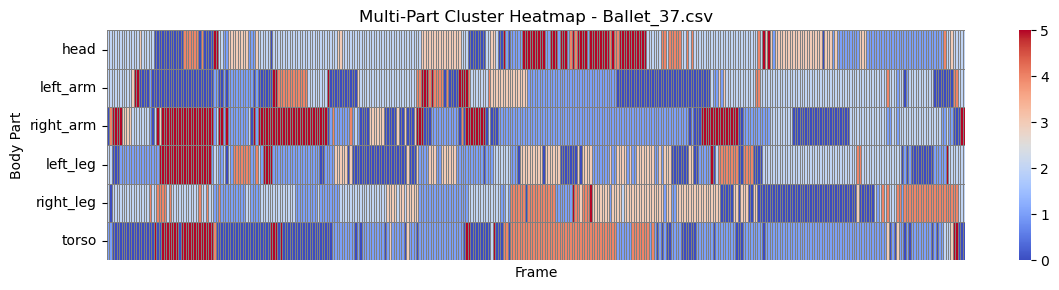

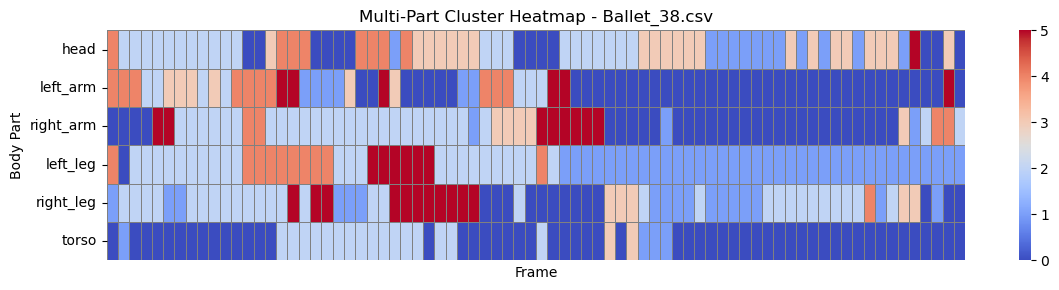

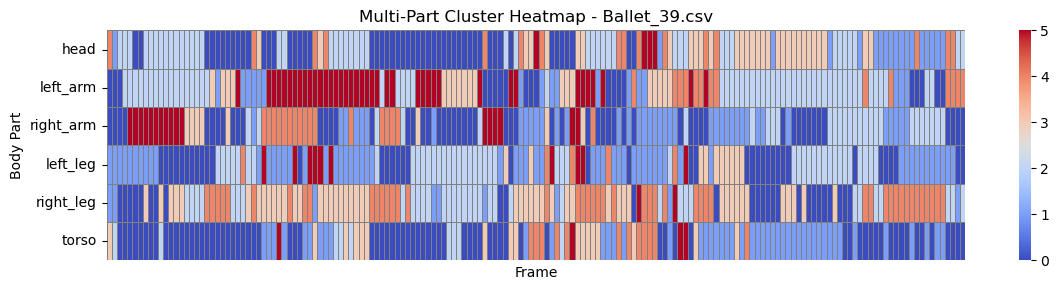

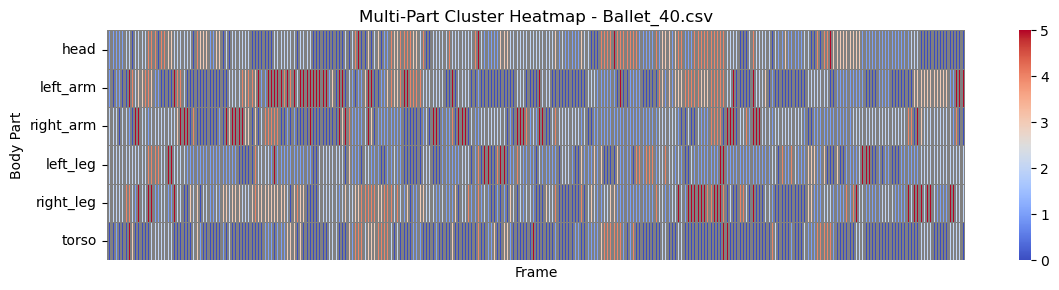

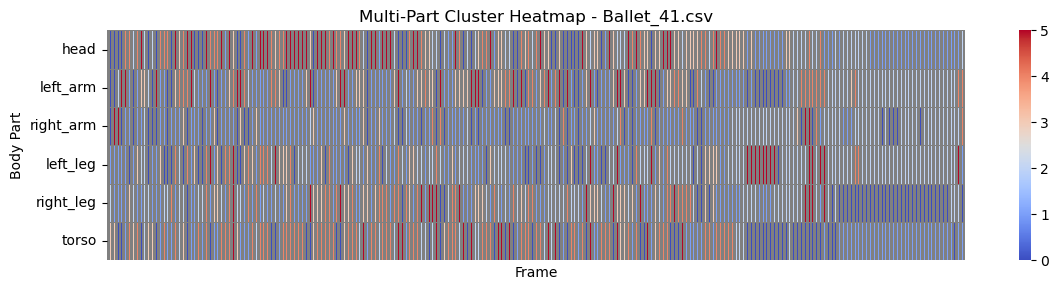

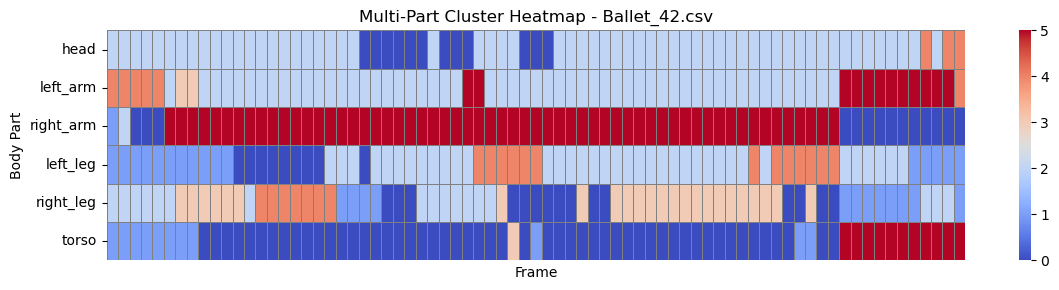

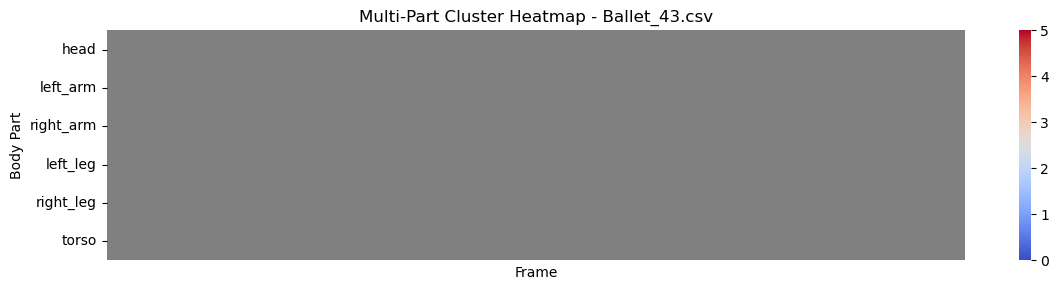

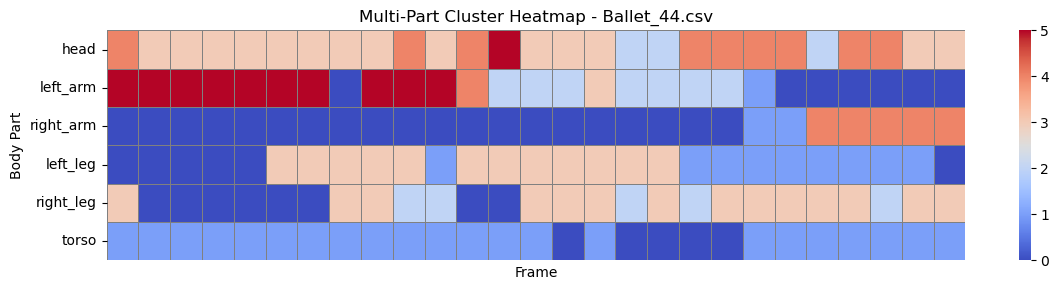

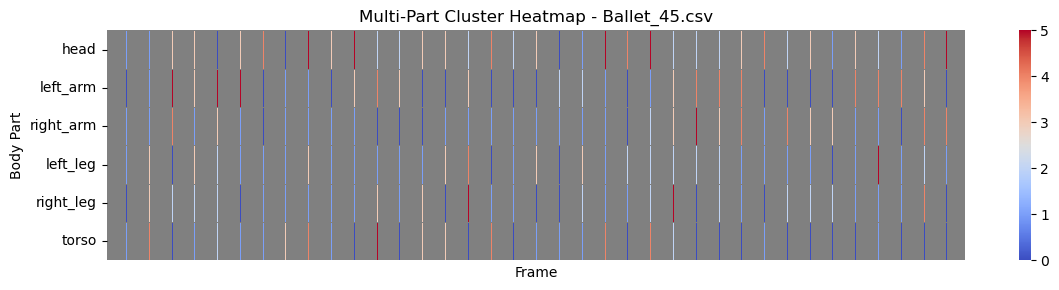

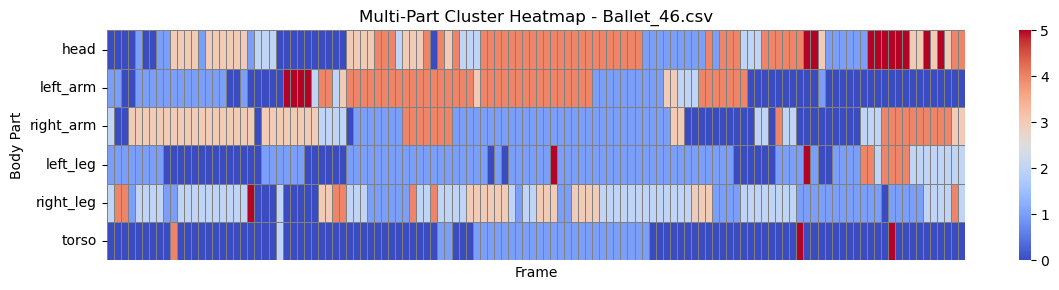

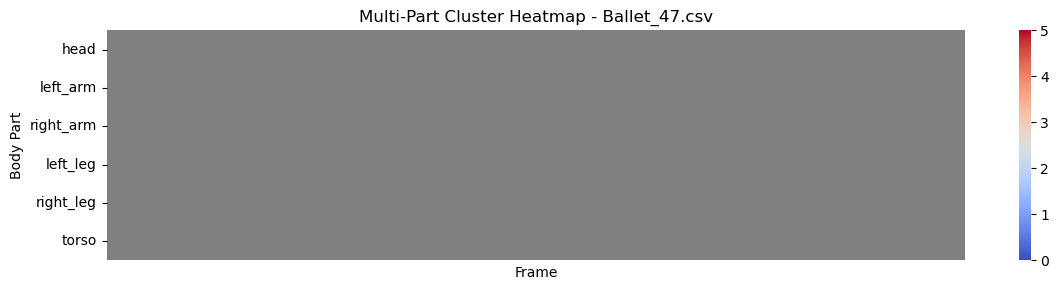

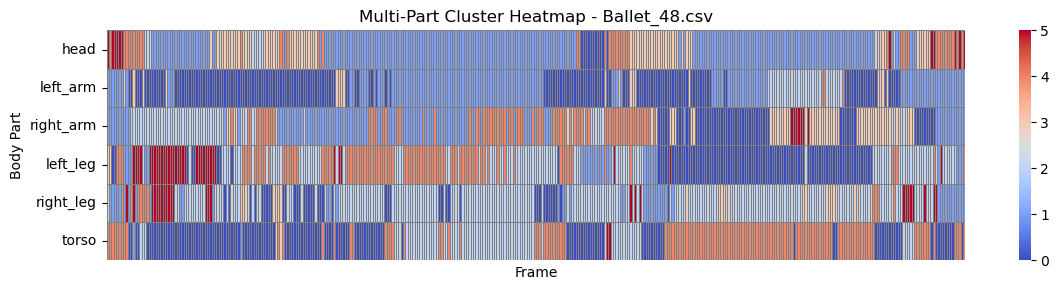

In [11]:
# 讀取你的多部位分群 JSON
with open("ballet_multi_part_clusters.json", "r", encoding="utf-8") as f:
    multi_data = json.load(f)

body_parts = ["head", "left_arm", "right_arm", "left_leg", "right_leg", "torso"]

for file_name, frame_data in multi_data.items():
    data = np.array(frame_data).T  # shape: (6, frames)
    plt.figure(figsize=(12, 3))
    sns.heatmap(data, cmap="coolwarm", cbar=True, square=False,
                xticklabels=False, yticklabels=body_parts,
                linewidths=0.5, linecolor="gray")
    plt.title(f"Multi-Part Cluster Heatmap - {file_name}")
    plt.xlabel("Frame")
    plt.ylabel("Body Part")
    plt.tight_layout()
    plt.show()

In [12]:
from mpl_toolkits.mplot3d import Axes3D
# Mediapipe Pose 的連線關係（常見33點骨架）
mp_connections = [
    (0,1), (1,2), (2,3), (3,7),        # 頭部與右耳
    (0,4), (4,5), (5,6), (6,8),        # 頭部與左耳
    (9,10),                            # 肩膀連線
    (11,12),                           # 左右肩膀
    (11,13), (13,15), (15,17), (15,19), (15,21),  # 左手
    (12,14), (14,16), (16,18), (16,20), (16,22),  # 右手
    (11,23), (12,24), (23,24),          # 軀幹
    (23,25), (25,27), (27,29), (27,31), # 左腿
    (24,26), (26,28), (28,30), (28,32)  # 右腿
]

def plot_pose_3d(pose_points, title=None):
    """
    pose_points: np.array shape (33, 3)
    """
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    # 抽取 x, y, z 座標
    x = pose_points[:, 0]
    y = pose_points[:, 1]
    z = pose_points[:, 2]

    # 畫出關節連線
    for (i, j) in mp_connections:
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 'gray', lw=1)

    # 畫出關節點
    ax.scatter(x, y, z, c='red', s=20)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=15, azim=70)
    ax.set_title(title if title else "3D Pose Skeleton")

    # 讓比例一致
    max_range = np.ptp([x, y, z])
    mid_x, mid_y, mid_z = np.mean(x), np.mean(y), np.mean(z)
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    plt.show()

共有 20 幀屬於 right_arm 的 cluster 0


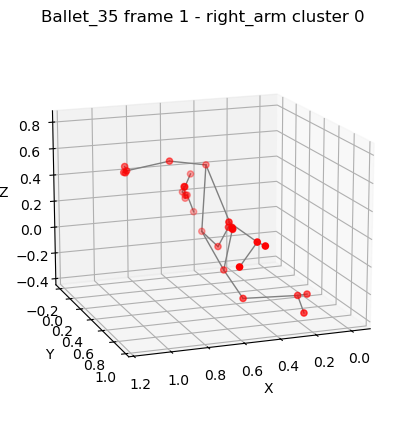

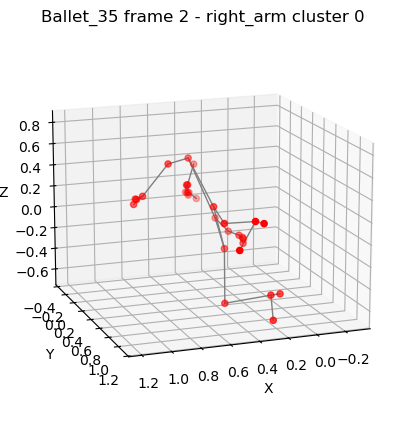

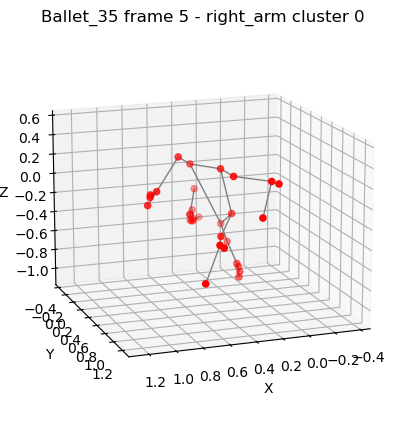

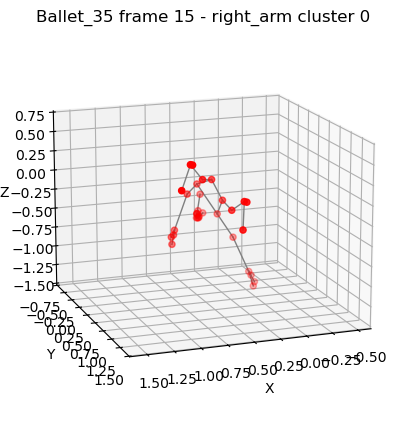

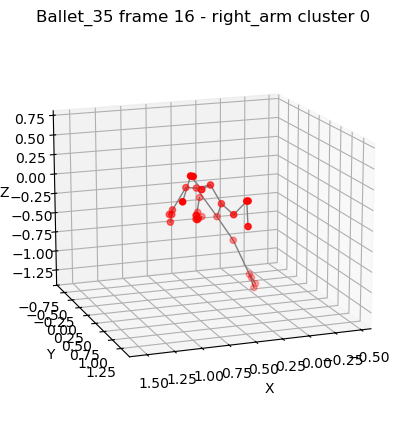

In [13]:
# 例如查看右手臂 cluster 3 對應的姿勢
target_part = "right_arm"
target_cluster = 0

# 找出這群的所有 frame
indices = np.where(np.array(multi_data["Ballet_35.csv"])[:, 2] == target_cluster)[0]
print(f"共有 {len(indices)} 幀屬於 {target_part} 的 cluster {target_cluster}")

# 取其中幾幀畫出骨架姿勢
for i in indices[:5]:
    pose = file_pose_map["Ballet_35.csv"][i]  # shape (99,)
    pose = pose.reshape(33, 3)                
    plot_pose_3d(pose, title=f"Ballet_35 frame {i} - right_arm cluster 0")